# How to visualize meshes with overlay? 

In [1]:
import pyvista as pv

from polpo.preprocessing import Map
from polpo.preprocessing.load.pregnancy import FigsharePregnancyDataLoader
from polpo.preprocessing.mesh.conversion import PvFromData
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.transform import MeshCenterer, MeshScaler
from polpo.preprocessing.mri import (
    MeshExtractorFromSegmentedImage,
    MriImageLoader,
)
from polpo.preprocessing.path import FileFinder, FileRule

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

Following [How to get a mesh from an MRI image?](./mri2mesh.ipynb), we download a segmented MRI and get a mesh out of it.

In [3]:
SESSION_ID = 2

In [4]:
folder_name = f"BB{str(SESSION_ID).zfill(2)}"

loader = FigsharePregnancyDataLoader(
    data_dir="~/.herbrain/data/pregnancy/Segmentations",
    remote_path=f"Segmentations/{folder_name}",
)

finder = FileFinder(
    rules=[
        FileRule(value="left", func="startswith"),
        FileRule(value=".nii.gz", func="endswith"),
    ]
)

loading_pipe = loader + finder + MriImageLoader()
img2mesh_pipe = MeshExtractorFromSegmentedImage() + PvFromData()

pipe = loading_pipe + img2mesh_pipe

raw_mesh = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/Segmentations/BB02').


We also load a registered version of the same mesh (NB: there's more registrations at [figshare](https://figshare.com/articles/dataset/pregnancy-data/28339535)).

In [5]:
loader = (
    FigsharePregnancyDataLoader(
        data_dir="~/.herbrain/data/pregnancy/registration",
        remote_path="registration/elastic_20250106_80",
    )
    + FileFinder(
        rules=[
            FileRule(value=f"left_{str(SESSION_ID).zfill(2)}", func="startswith"),
            FileRule(value=".ply", func="endswith"),
        ],
    )
    + PvReader()
)

registered_mesh = loader()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/registration/elastic_20250106_80').


The registered mesh was preprocessed before registration. Let's apply the same preprocessing in order to have an overlayable representation.

In [6]:
processing_pipe = Map(
    [MeshCenterer(), MeshScaler()],
    force_iter=True,
)

raw_mesh = processing_pipe(raw_mesh)

Visualization.

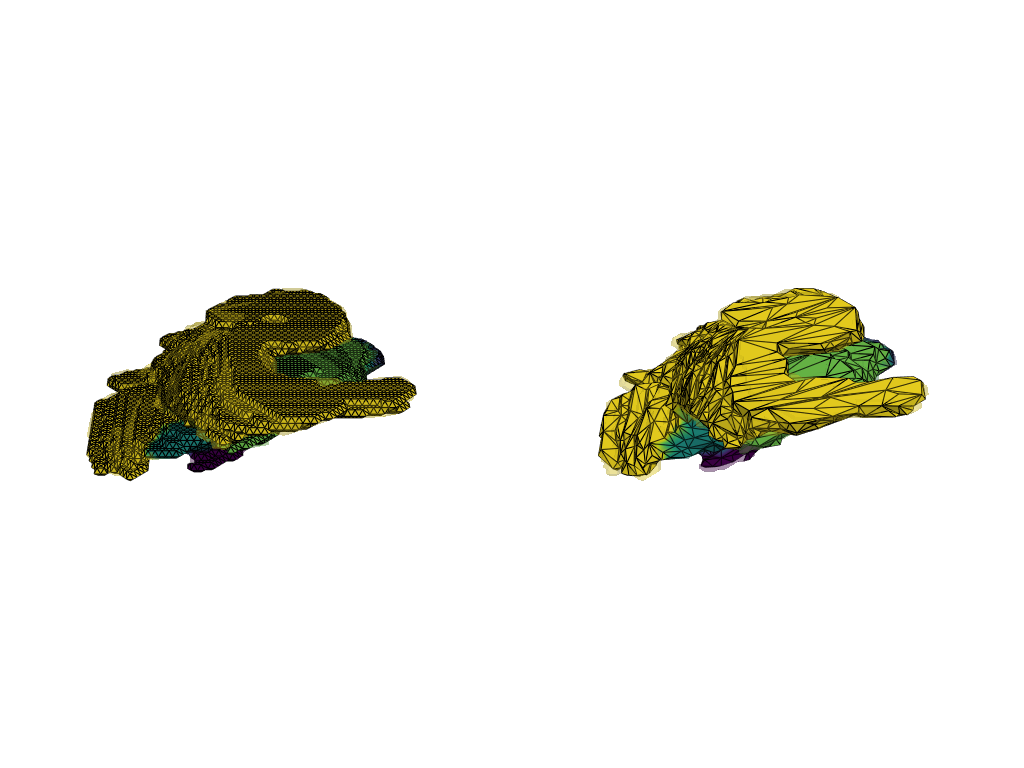

In [7]:
pl = pv.Plotter(shape=(1, 2), border=False)

pl.subplot(0, 0)
pl.add_mesh(raw_mesh, show_edges=True)
pl.add_mesh(registered_mesh, opacity=0.25)
pl.remove_scalar_bar()

pl.subplot(0, 1)
pl.add_mesh(registered_mesh, show_edges=True)
pl.add_mesh(raw_mesh, opacity=0.25)
pl.remove_scalar_bar()

pl.link_views()

pl.show()

Notice the meshes fully overlap even though they have a very different combinatorial structure.

In [8]:
(
    raw_mesh.faces.shape[0] // 3,
    registered_mesh.faces.shape[0] // 3,
)

(27680, 6032)